# Predicting the Quality of Vinho Verde Wine Based on Physical Properties
## DSCI 100 Project Final Report
Date: November/December 2022

Group: 157

## Proposal Overview
- Introduction
- Methods & Results
- Discussion
- References

## Introduction

There are many factors that give white wine its distinctive taste. Sweetness is determined by **residual sugars** left over from fermentation, and is measured in grams per decimeter cubed. The sugars that were consumed during fermentation determine the **alcohol content** of the wine – grapes with more sugar create more alcoholic wines. The tart or sour taste of the wine comes from its **acidity**. All wine has a **pH** between 3 and 4, but small variations in acidity can create a big difference in taste. Other properties such as **citric acid**, **sulfur dioxide**, **chlorides**, and **sulfates** also affect the quality of the wine.

In our project, we ask, what physical properties lead to a higher quality white wine? To solve this problem, we will be using data from approximately 5,000 variants of the Portuguese wine “Vinho Verde” collected by Cortez et al. (2009). 

Though all variables provided affect the quality of a wine, we chose a subset of the variables based on which appeared to have an obvious relationship with quality (summarized in the following section) in addition to what was of interest to us. The variables we will be using in our analysis of white wine quality are:
- Fixed acidity (g/dm^3)
- Citric acid (g/dm^3)
- Residual sugar (g/dm^3)
- pH (logarithmic units, from 1-12)
- Alcohol (volume percent, from 0 to 100)
- Quality (a score, from 3-9, with 9 being the best quality)

## Methods & Results

We used a K-nearest neighbours (KNN) algorithm to build our classifier. KNN functions by using the “nearest” or most similar data point(s) (neighbour(s), or K) to an unknown observation in order to predict its class. Predicting is done through a voting system, in which the most common class among multiple closest neighbours, or the class of a single closest neighbour, is assigned as the predicted class of the unknown observation (Timbers et al., 2022).

#### Importing relevant libraries

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Importing data from the web

The first step in building our model is to import our data from the web. The white wine data set was provided by Cortez et al. (2009) for their study *Modeling wine preferences by data mining from physicochemical properties*.

In [2]:
data <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delim = ";")

Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Tidying the data

Next, we tidied the data so we were working with a class that is a factor, as well as to include only wines of quality 4 through 8. Wines of quality 3 and 9 had very few data points to work with, so we decided to exclude them. In a future iteration of this project, it may be possible to use resampling to combat the class imbalance.

In [3]:
wine <- wine |>
    filter(quality > 3 & quality < 9) |>
    mutate(quality = as.factor(quality))

colnames(wine) <- make.names(colnames(wine))
"Table 1. Preview of the tidied data"
head(wine)

[1] "Table 1. Preview of the tidied data"

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6


#### Splitting the data

We split the data into a training (75%)  and testing (25%)  group, stratified by quality. Stratifying ensures that we have equal proportions of each quality of wine in each group, so there is proper representation of the entire dataset in both the training and testing sets.

In [4]:
set.seed(1234)
wine_split <- initial_split(wine, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

#### Summarizing the data in tables

We made tables to familiarize ourselves with the dataset, using only the training data.

In [5]:
#Variables available to us
#colnames(wine)

# Get the number of observations and their respective percentage of each quality in the training set
wine_prop <- group_by(wine_training, quality) |> 
    summarize(n = n()) |>
    mutate(percent = round(100 * n / sum(n), digits = 1))

"Table 2. Proportion of wines of each quality in the dataset"
wine_prop

[1] "Table 2. Proportion of wines of each quality in the dataset"

quality,n,percent
<fct>,<int>,<dbl>
4,121,3.3
5,1093,29.9
6,1654,45.3
7,655,17.9
8,131,3.6


**Table 2** shows the number of observations for each quality of wine and their proportion of the dataset for the training data.

In [6]:
"Table 3. Average value of each variable for each quality of wine"
quality_averages <- wine_training |>
    group_by(quality) |>
    summarise(across(everything(), mean))

quality_averages

[1] "Table 3. Average value of each variable for each quality of wine"

quality,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,7.165289,0.3806612,0.3104959,5.161983,0.04734711,24.36364,126.8017,0.9944659,3.175868,0.4794215,10.170661
5,6.934858,0.3024794,0.3391034,7.363678,0.05164776,36.35133,150.5169,0.9952561,3.168435,0.4814730,9.823617
6,6.843440,0.2601300,0.3370798,6.472763,0.04500786,36.13573,137.3863,0.9939775,3.185109,0.4900726,10.553013
7,6.741069,0.2618015,0.3261832,5.221069,0.03828397,34.34656,125.3885,0.9925305,3.217252,0.5124580,11.333781
8,6.674809,0.2723282,0.3243511,5.906107,0.03865649,36.96183,126.1374,0.9923221,3.211603,0.4861832,11.619847


**Table 3** shows the average value for each variable for each quality of wine. This allowed us to gain a broad overview of how variables change as wine quality changes. We selected variables for our analysis based on how much they changed with quality as well as what elements we found interesting.

#### Visualizing the data

The following visualizations were made using only the training data, and further helped us to get acquainted with our dataset and visualize patterns.

Warning message:
“Removed 62 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 22 rows containing missing values (geom_bar).”


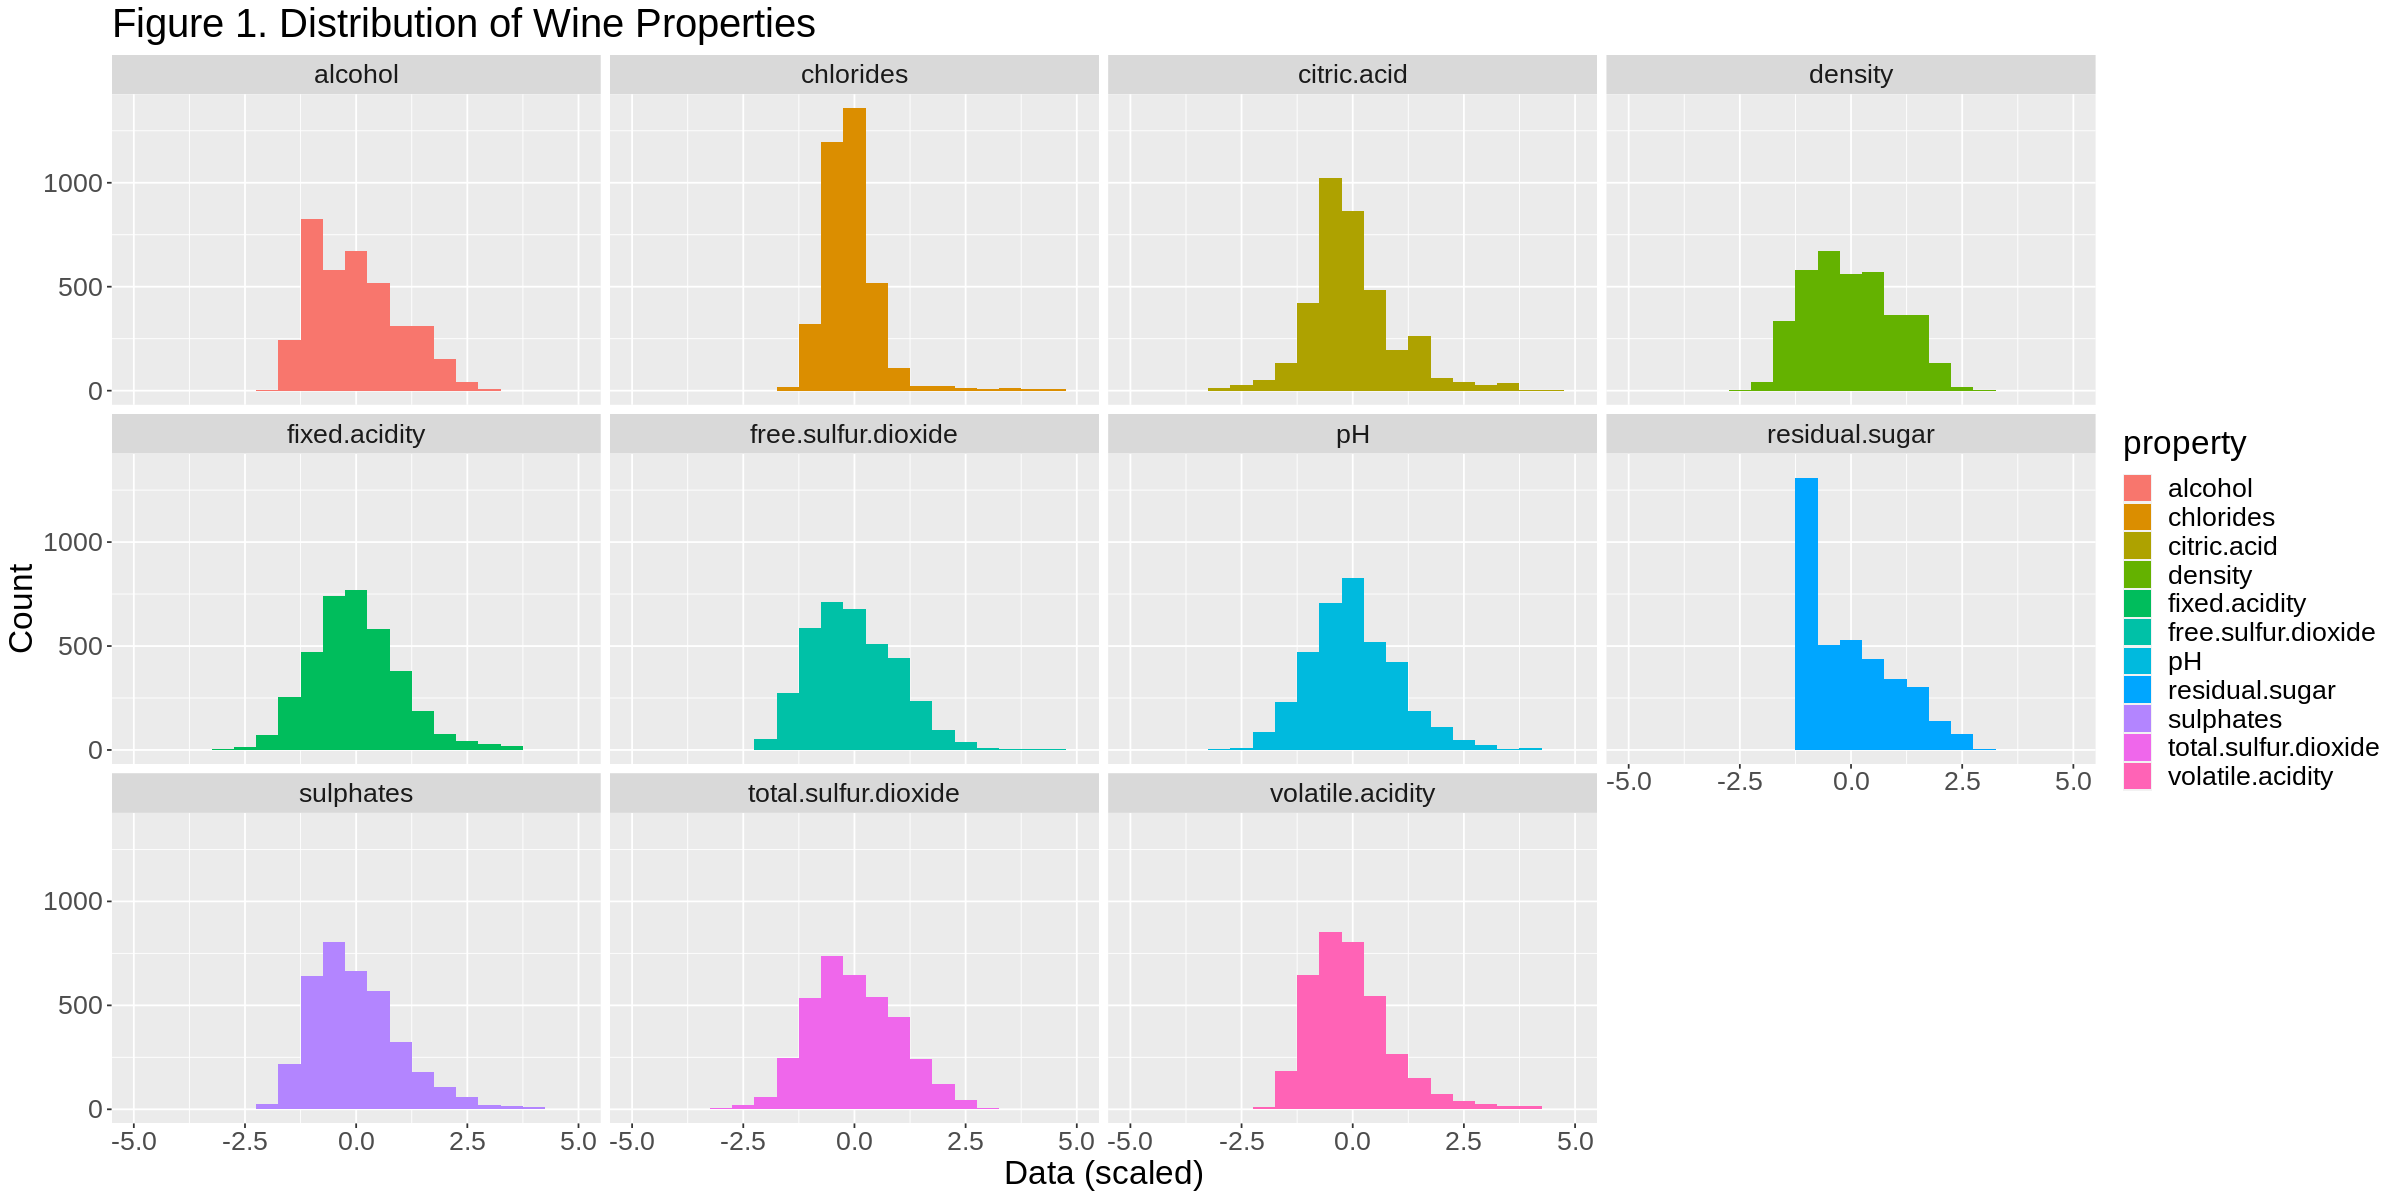

In [7]:
wine_scaled <- select(wine_training, fixed.acidity:alcohol) |>
    scale() |>
    as.data.frame() |>
    pivot_longer(fixed.acidity:alcohol , names_to = "property", values_to = "value")

options(repr.plot.width = 20, repr.plot.height = 10)

frequency_dist <- ggplot(wine_scaled, aes(x=value,fill=property)) +
    geom_histogram(binwidth = 0.5) +
    facet_wrap(~ property) + 
    xlab("Data (scaled)") + 
    ylab("Count") +
    ggtitle("Figure 1. Distribution of Wine Properties") + 
    xlim(-5, 5) +
    theme(text = element_text(size = 20))

frequency_dist

**Figure 1** shows the distribution of the eleven different properties contained within our dataset. Most of these properties have a normal distribution, although some do not. Alcohol and residual sugars are noticeably left skewed, while citric acid has an unusually high count at x=3.

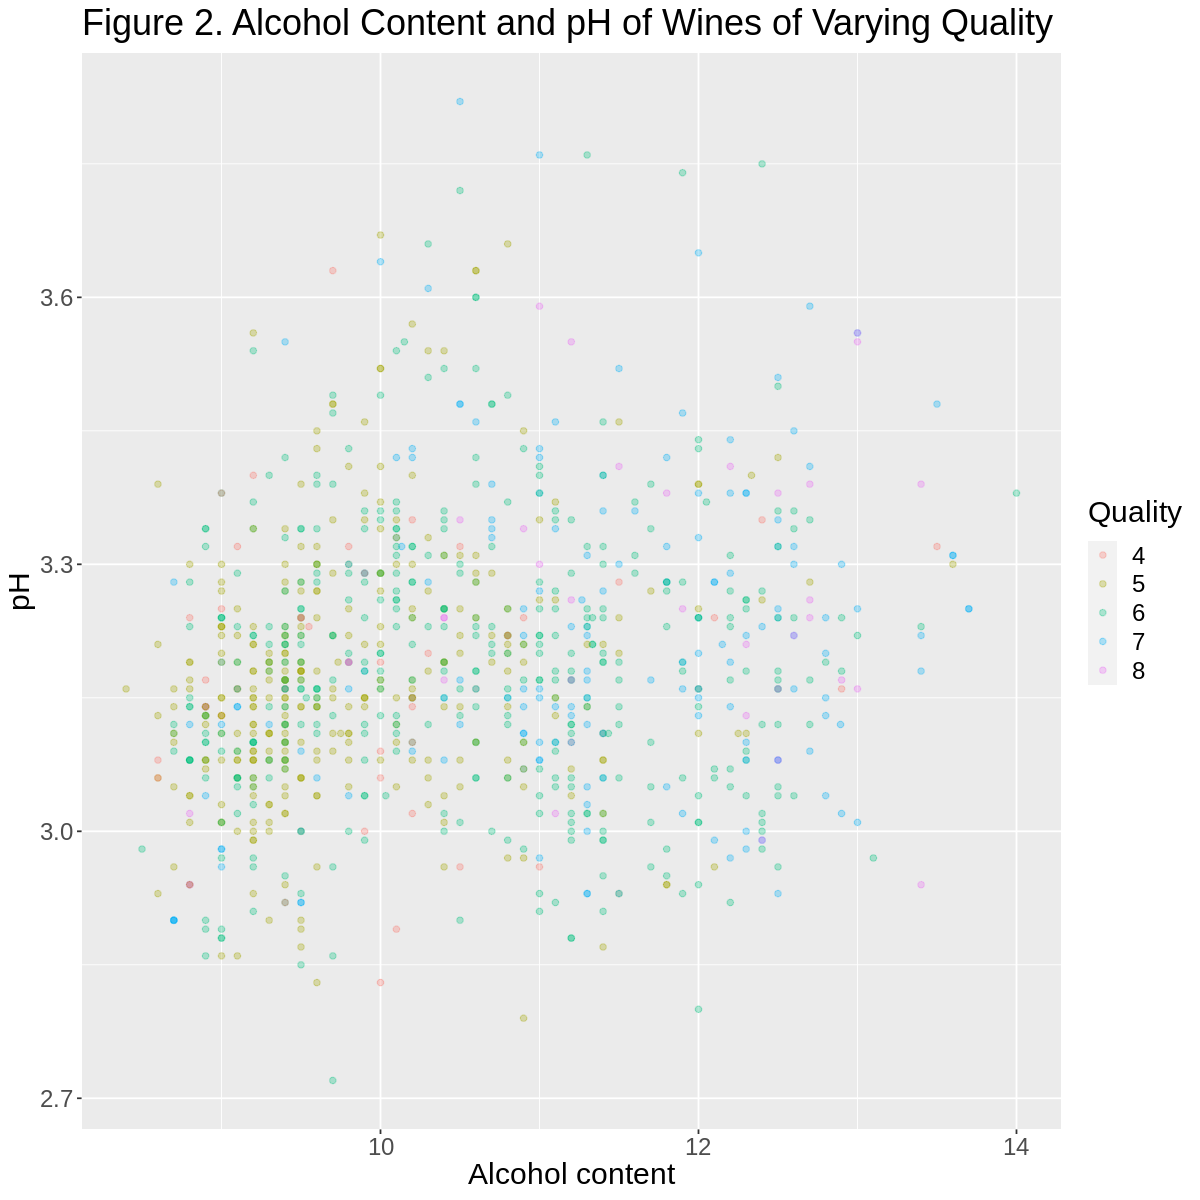

In [8]:
# Alcohol content, pH, and rating
set.seed(1234)
small_training <- rep_sample_n(wine_training, size = 1000)

options(repr.plot.width = 10, repr.plot.height = 10)

alcohol_ph_plot <- ggplot(small_training, aes(x = alcohol, y = pH, colour = quality)) +
    geom_point(alpha = 0.3) +
    labs(x = "Alcohol content", y = "pH", colour = "Quality") +
    theme(text = element_text(size = 18)) +
    ggtitle("Figure 2. Alcohol Content and pH of Wines of Varying Quality")

alcohol_ph_plot

**Figure 2** shows how wine quality changes as the variables pH and alcohol content change for a random subset of the training data. Wines with higher alcohol content tend to receive higher ratings. pH does not have as drastic of an effect, though some wines with higher pH have lower quality scores.

Warning message:
“Removed 4 rows containing missing values (geom_point).”


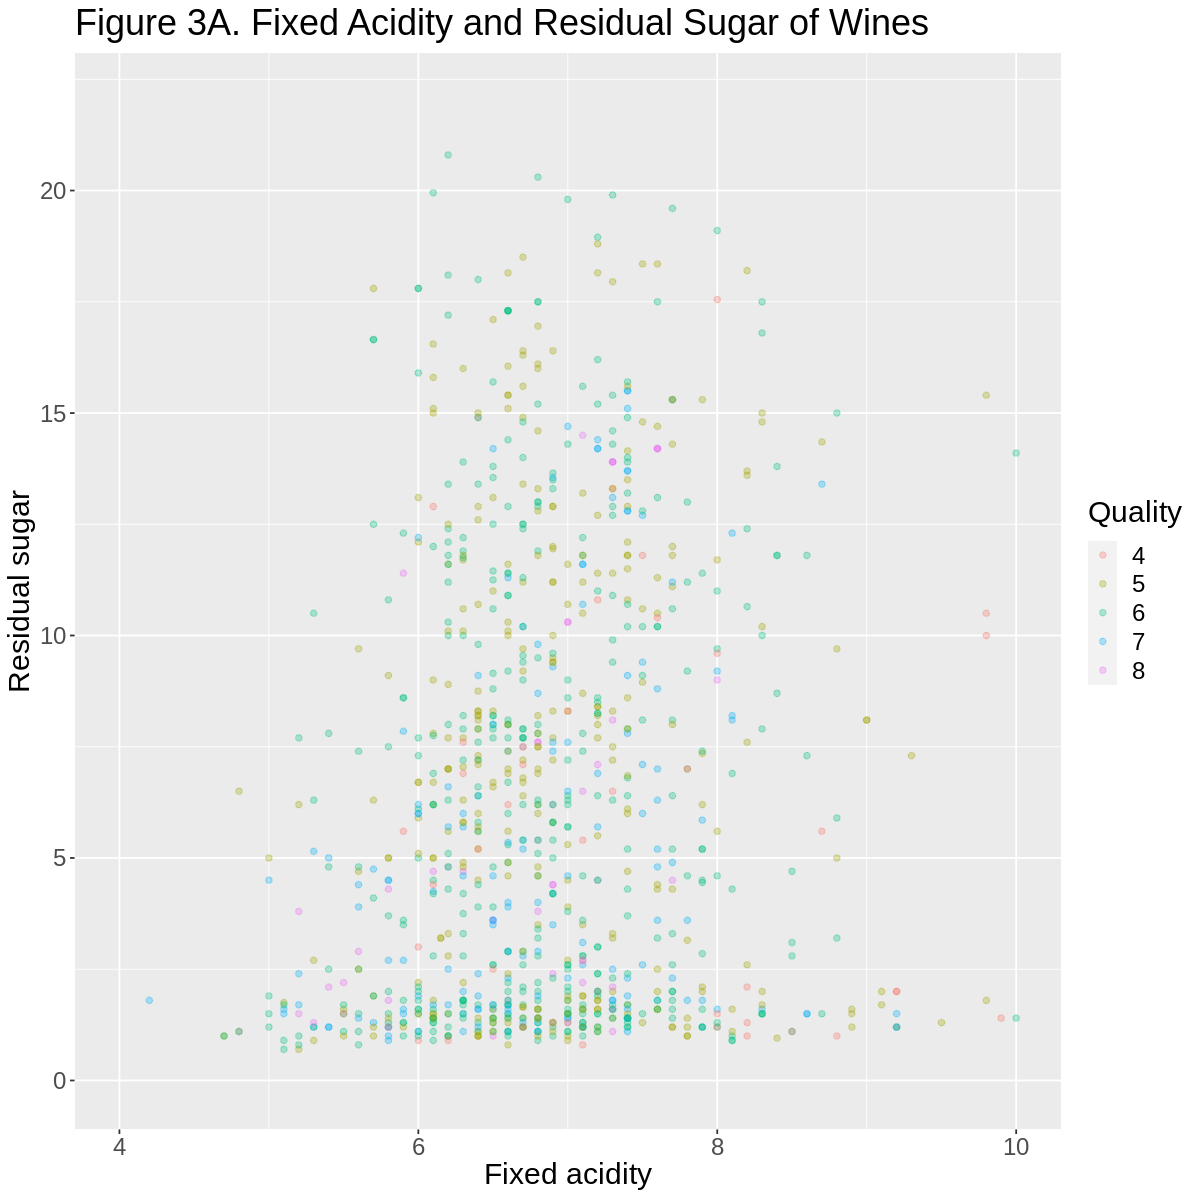

Warning message:
“Removed 4 rows containing missing values (geom_point).”


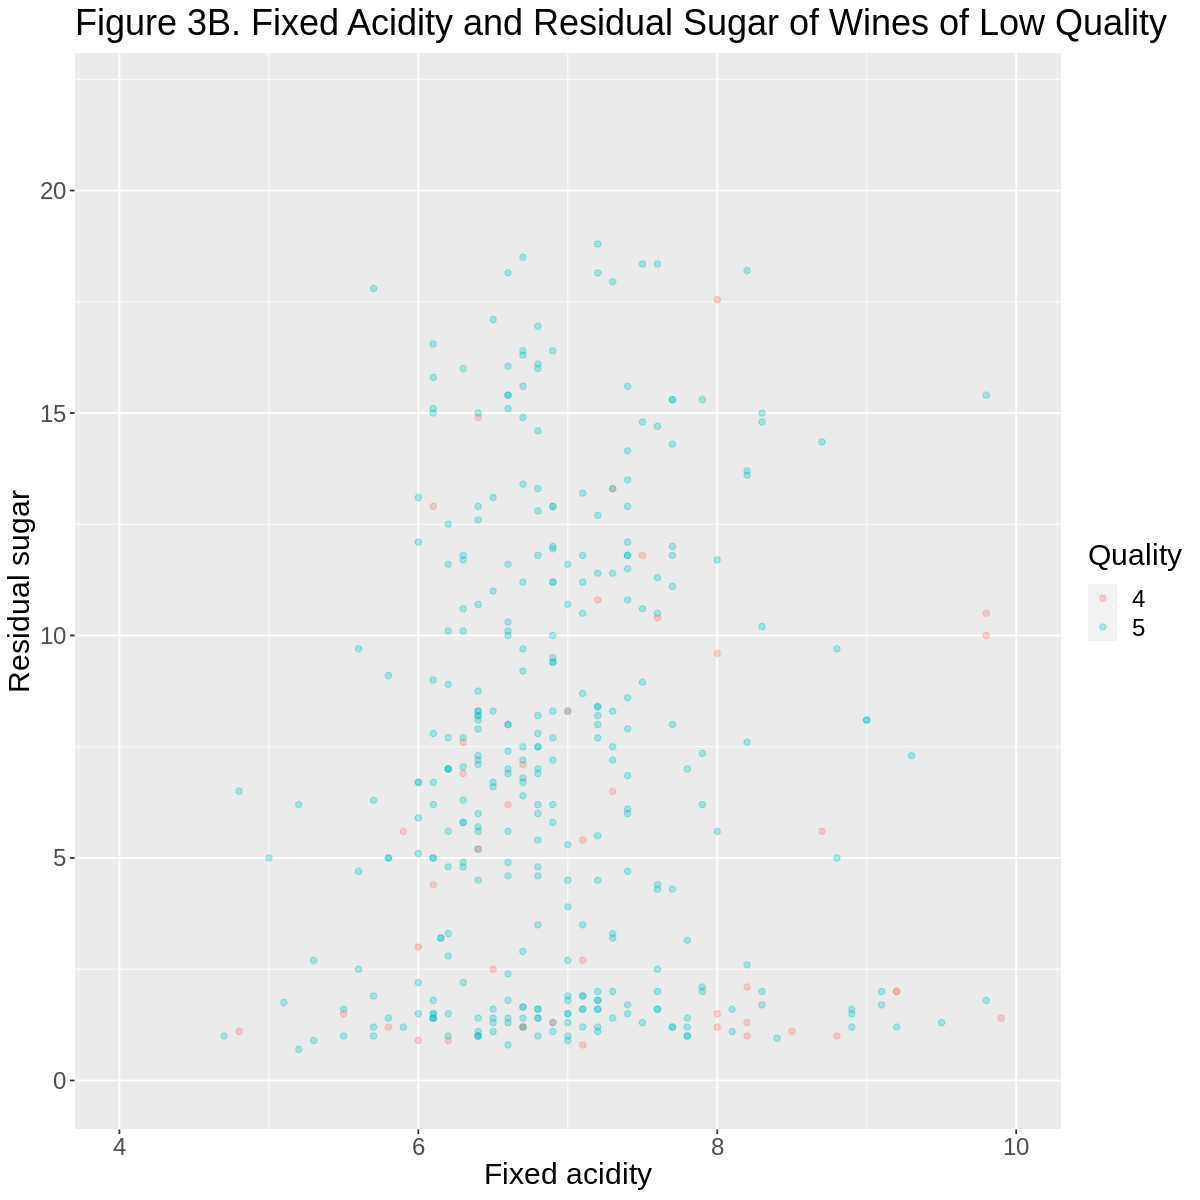

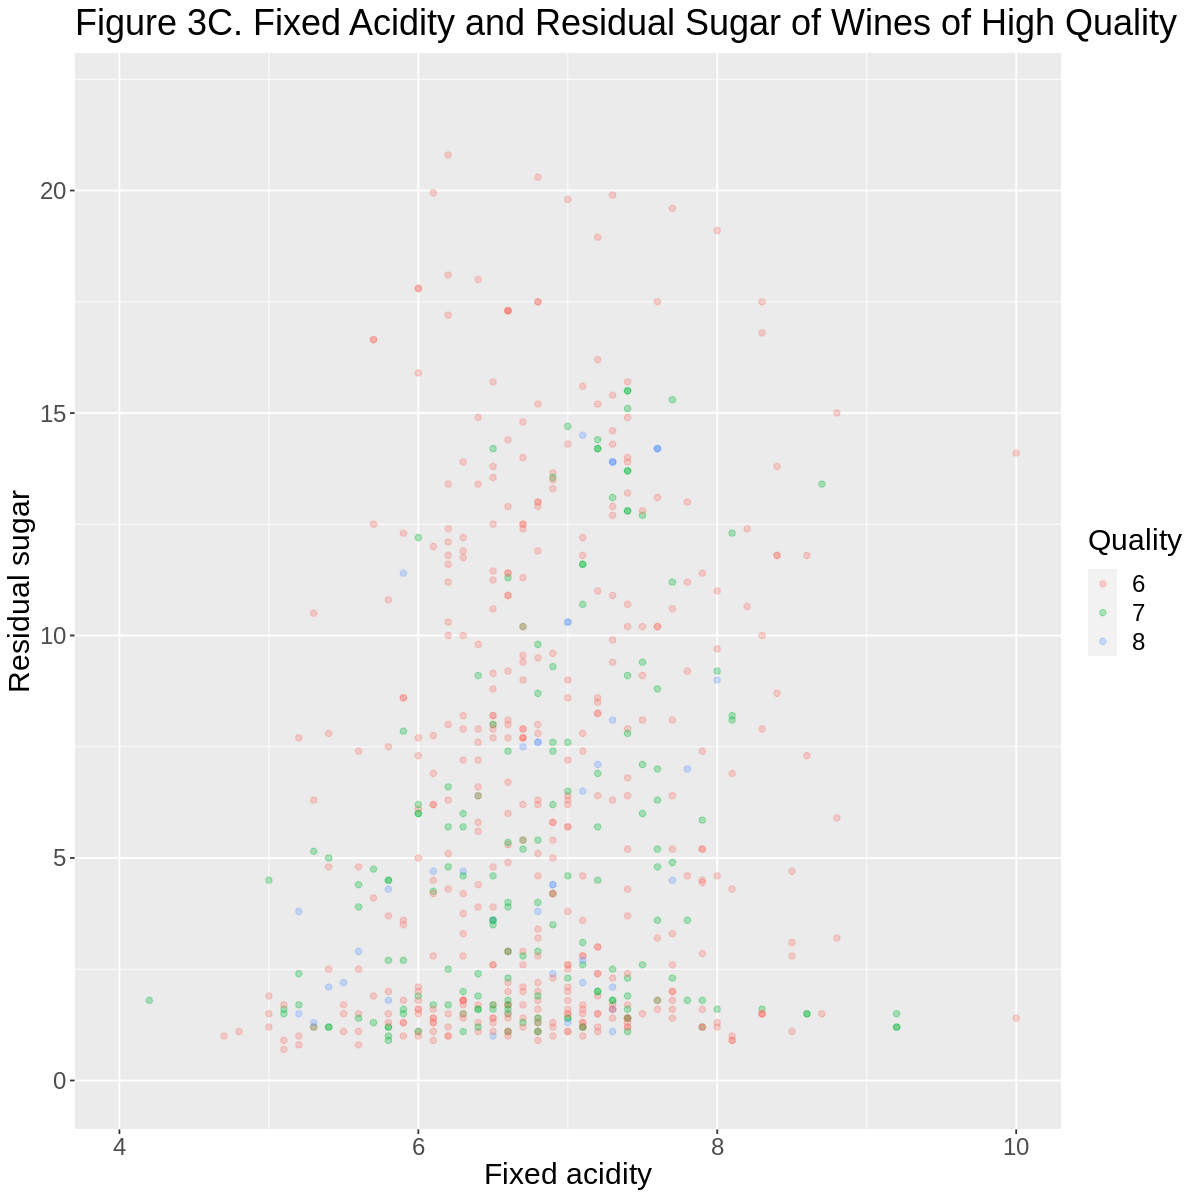

In [9]:
sugar_plot <- function(title, qualities = list("4", "5", "6", "7", "8")) {
    sugar_data <- filter(small_training, quality %in% qualities)
    return (ggplot(sugar_data, aes(x = fixed.acidity, y = residual.sugar, colour = quality)) +
        geom_point(alpha = 0.3) +
        labs(x = "Fixed acidity", y = "Residual sugar", colour = "Quality") +
        theme(text = element_text(size = 18)) +
        ggtitle(title) +
        xlim(4, 10) +
        ylim(0, 22))
}

sugar_plot("Figure 3A. Fixed Acidity and Residual Sugar of Wines")
sugar_plot("Figure 3B. Fixed Acidity and Residual Sugar of Wines of Low Quality", list("4", "5"))
sugar_plot("Figure 3C. Fixed Acidity and Residual Sugar of Wines of High Quality", list("6", "7", "8"))

**Figure 3A** shows how wine quality changes for a random subset of the training data as the variables fixed acidity and residual sugar change. Many wines with higher fixed acidity have lower quality scores. The trends for residual sugars are hard to determine. **Figure 3B** and **3C** split this data into low (≤ 5) and high (≥ 6) quality wines to better see possible trends. Higher quality wines appear to have a more balanced (in the middle) residual sugar profile.

#### Designing the model

To design our model, we first created a 10-fold split for cross validation. The purpose of cross validation is to better evaluate the accuracy of our model given our limited data (Brownlee, 2020). We also normalized our data by scaling and centering our variables. Normalization is a critical step for KNN classification, as neighbour selection is based on euclidean distance, which may be inaccurate if the scale of our variables is not the same, leading to inaccurate predictions. Finally, we tuned the parameter K of our model, testing 10 different values (1 through 10), in order to determine what number of neighbours gave us the highest accuracy.

In [15]:
set.seed(1234)

wine_vfold <- vfold_cv(wine_training, v = 10, strata = quality)

wine_recipe <- recipe(quality ~ fixed.acidity + citric.acid + residual.sugar + pH + alcohol, data = wine_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

grid_vals <- tibble(neighbors = seq(from=1, to=10, by=1))

knn_results <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = wine_vfold, grid = grid_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean, std_err)

"Table 4. Model accuracy for each value of K"
knn_results

[1] "Table 4. Model accuracy for each value of K"

neighbors,mean,std_err
<dbl>,<dbl>,<dbl>
1,0.5878334,0.006759283
2,0.5878334,0.006759283
3,0.5363951,0.007559514
4,0.5273577,0.007620707
5,0.5246165,0.008826419
6,0.5238103,0.008024852
7,0.5191692,0.006730465
8,0.5120563,0.006353128
9,0.5022232,0.008185574


**Table 4** shows the accuracy (mean) and standard deviation (std_err) for the model with different values of K (1 to 10). The accuracy is an average over 10 folds through cross validation. One and two neighbours give the greatest accuracy, each with a value of 58.78% (S.D. = 0.68%).

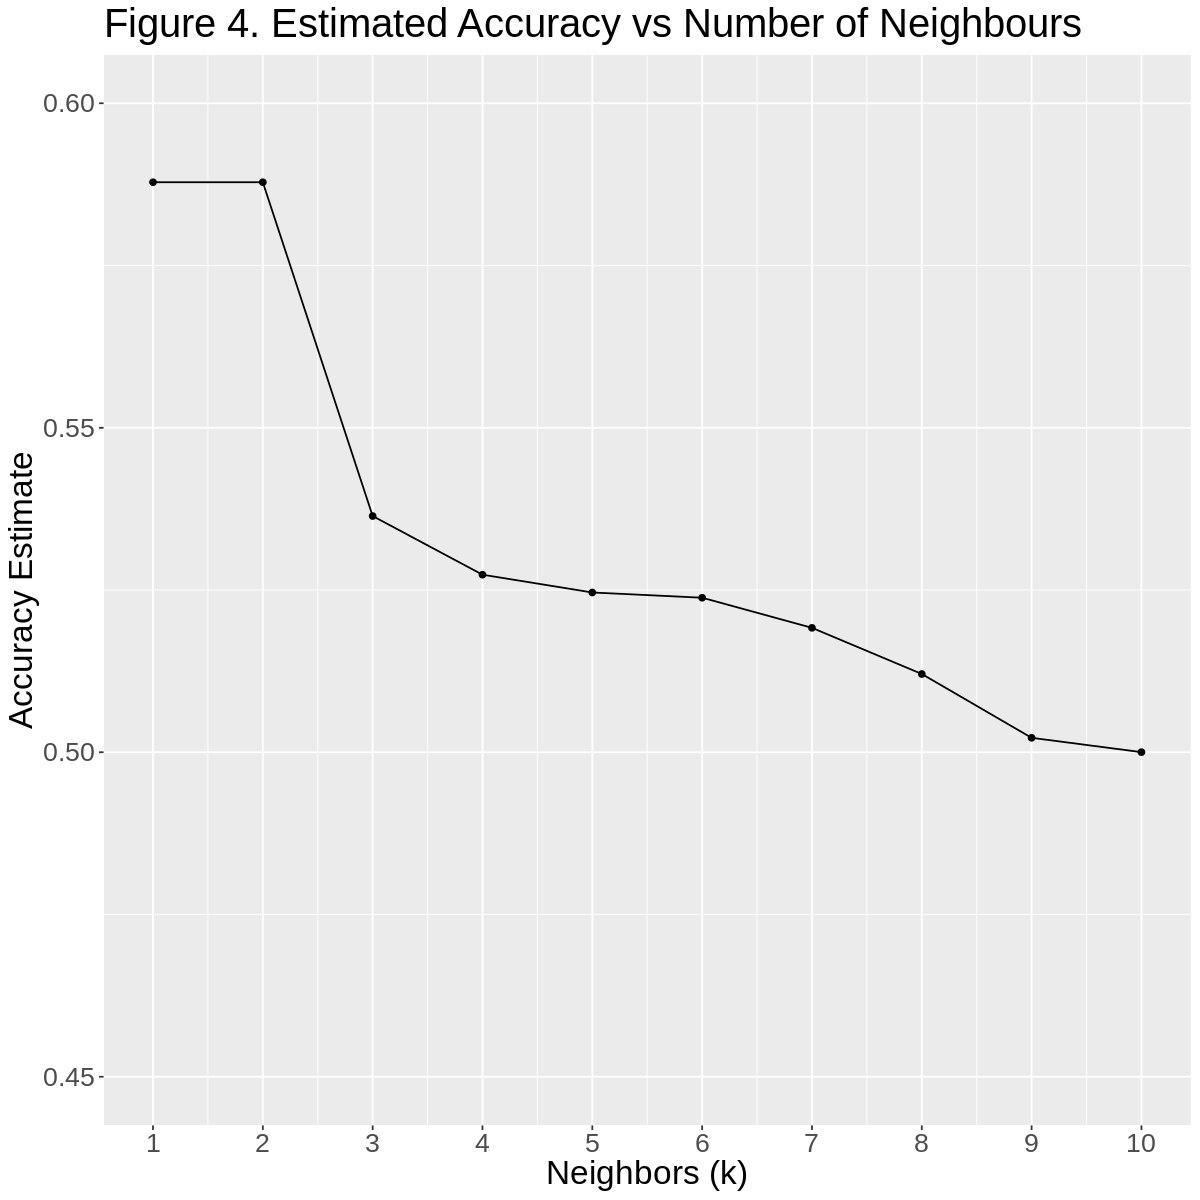

In [16]:
cross_val_plot <- ggplot(knn_results, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors (k)", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 10, by = 1)) +
    scale_y_continuous(limits = c(0.45, 0.6)) +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 4. Estimated Accuracy vs Number of Neighbours")

cross_val_plot

**Figure 4** shows the accuracy (as an average over 10 folds) of our model for the training data for different values of K (neighbours).

#### Building the model with best K

We designed a final model for predicting white wine quality with the best K as given by Figure 4. Both K = 1 and K = 2 had the same accuracy. We decided to use K = 2.

In [12]:
set.seed(1234)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
       set_engine("kknn") |>
       set_mode("classification")

wine_fit <- workflow() |>
       add_recipe(wine_recipe) |>
       add_model(knn_spec) |>
       fit(data = wine_training)

#### Predicting with the model

Finally, we were able to use our model to make predictions on the testing set. Following this, we collected metrics including overall accuracy as well as a confusion matrix to better visualize which classes the model had difficulty predicting.

In [13]:
set.seed(1234)
"Table 3. Predictions vs Actual"
wine_test_predictions <- predict(wine_fit , wine_testing) |>
       bind_cols(wine_testing)
head(wine_test_predictions)

[1] "Table 3. Predictions vs Actual"

.pred_class,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,6.3,0.30,0.34,1.60,0.049,14,132,0.9940,3.30,0.49,9.5,6
6,8.1,0.27,0.41,1.45,0.033,11,63,0.9908,2.99,0.56,12.0,5
6,7.9,0.18,0.37,1.20,0.040,16,75,0.9920,3.18,0.63,10.8,5
5,7.4,0.34,0.42,1.10,0.033,17,171,0.9917,3.12,0.53,11.3,6
8,6.2,0.66,0.48,1.20,0.029,29,75,0.9892,3.33,0.39,12.8,8
6,6.4,0.31,0.38,2.90,0.038,19,102,0.9912,3.17,0.35,11.0,7


**Table 3** shows a snippet of the predicted qualities of each observation in the testing set.

[1] "Table 4. Accuracy"

.metric,.estimate
<chr>,<dbl>
accuracy,0.6160788


[1] "Table 5. Confusion Matrix"

          Truth
Prediction   4   5   6   7   8
         4   9   9   9   1   1
         5  16 231 100  17   3
         6  12 112 358  64   8
         7   5  11  68 135  14
         8   0   1   9   8  18

[1] "Figure 5. Confusion Matrix Heat Map"

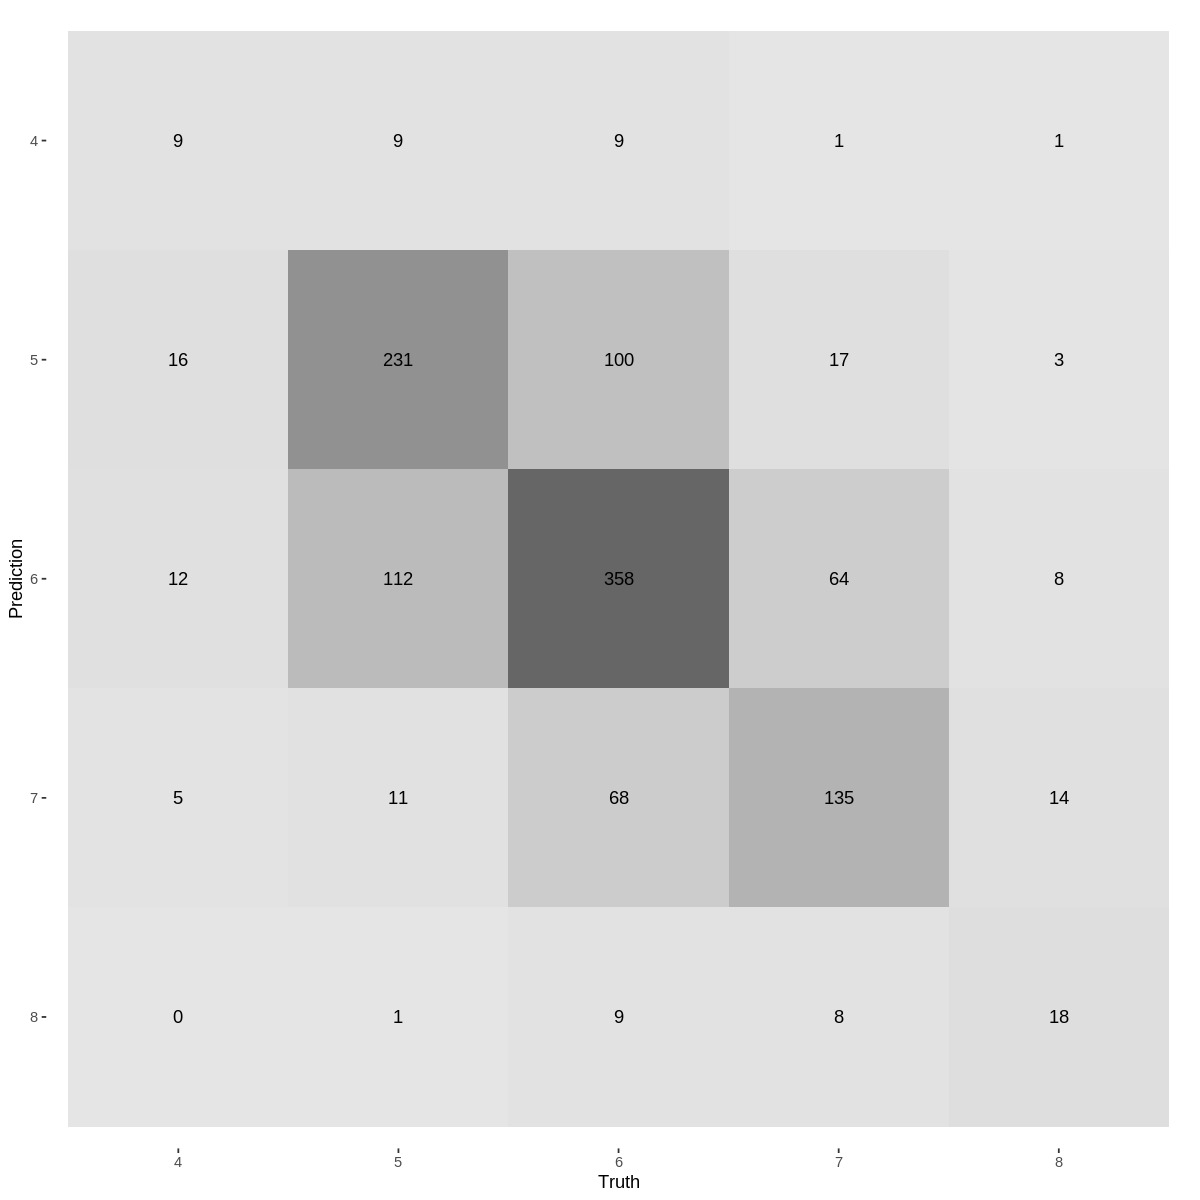

In [14]:
set.seed(1234)
"Table 4. Accuracy"
wine_prediction_accuracy <- wine_test_predictions |>
    metrics(truth = quality, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(-.estimator)
wine_prediction_accuracy

"Table 5. Confusion Matrix"
wine_mat <- wine_test_predictions |> 
      conf_mat(truth = quality, estimate = .pred_class)  
wine_mat
"Figure 5. Confusion Matrix Heat Map"
autoplot(wine_mat, type = "heatmap")

**Table 4** shows the accuracy of our model is 61.61% for the testing data. 

**Table 5** reports the confusion matrix, summarizing the prediction results against the actual qualities. 

**Figure 5** provides a visualization of the confusion matrix in the form of a heat map, with darker squares indicating a larger number of predictions.

## Conclusion

We created a KNN classification model to predict the quality (a score of 4 to 8) of white wines based on fixed acidity, citric acid, residual sugar, pH, and alcohol. The accuracy of our model is 61.61%, which is too low for our commercial or professional use by white wine companies to accurately predict quality score. According to the accuracy, should this model be used as is, it would only predict correct wine quality a little over half time.

Because the accuracy of our model on the testing set (61.61%) is very close to that of the training set (58.78%) we can conclude that overfitting did not occur. Overfitting is the result of the model “knowing” the training set too well, and thus we would expect the accuracy for the training data to be much greater than that of the testing data in the case of overfitting.

The confusion matrix provides us with more information by examining how well the model made predictions for each class. The confusion matrix can also provide us information on the sensitivity and specificity of our model (2021), however these metrics are beyond the scope of this course. As visualized in Figure 5, our model best predicted quality 6, with qualities 5 and 7 as close seconds. The model poorly predicted qualities 4 and 8. This is expected as it lines up with each quality’s respective proportion of the dataset. Since the amount of data points of qualities 4 and 8 are very small compared to the other 3 classes, it is unlikely that the classification of such rare qualities could be accurate. The number of datapoints of quality 6 is fairly large, so the model can better predict that class. Our model better predicts classes that have a large amount of samples.
 
To further improve our model, we can collect more data about white wines, since our model works well to predict the class which has a large amount of samples to train on. When the amount of all the classes are large enough, we believe our model will predict the quality of white wines more accurately. However, more data is not always an option. The KNN algorithm only has one tuning parameter – number of neighbours. A future model could use a different algorithm, such as random forest, neural network, or decision tree, as these models have a greater number of parameters that can be tuned to work best with our dataset. We could also explore more metrics, such as balanced accuracy, which is often used in a case of an unbalanced dataset to more accurately describe the model's performance (Olugbenga, 2022), or sensitivity and specificity as mentioned above, to better understand how our model performs.
 
Future modeling questions could involve bringing in human sensory data in addition to these chemical property data. We could ask, how does human sensory data (ex. taste) affect the score? How much does this vary from person to person? Additionally, if data on consumer habits and price were supplied, we could build a more valuable predictor for sales, production, and inventory.

## References

Brownlee, J. (2020, August 2). *A gentle introduction to k-fold cross-validation.* Machine Learning Mastery. Retrieved November 29, 2022, from https://machinelearningmastery.com/k-fold-cross-validation/ 

Finance Train. (2021, September 23). *Create a confusion matrix in R.* Finance Train. Retrieved November 29, 2022, from https://financetrain.com/create-a-confusion-matrix-in-r 

Olugbenga, M. (2022, November 14). *Balanced accuracy: When should you use it?* neptune.ai. Retrieved November 29, 2022, from https://neptune.ai/blog/balanced-accuracy 

Timbers, T., Campbell, T., & Lee, M. (2022, September 24). *Data Science: A First Introduction.* Retrieved November 29, 2022, from https://datasciencebook.ca/ 

### Data

Data for this project was sourced from:

Cortez P., Cerdeira A., Almeida F., Matos T. & Reis J. *Modeling wine preferences by data mining from physicochemical properties.* In Decision Support Systems, Elsevier, 47(4):547-553, 2009.